**Importing the dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/survey.csv')

In [ ]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,8/27/2014 11:29,37,Female,United States,IL,NaN,No,Yes,Often,25-Jun,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,8/27/2014 11:29,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,8/27/2014 11:29,32,Male,Canada,NaN,NaN,No,No,Rarely,25-Jun,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,8/27/2014 11:29,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,8/27/2014 11:30,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [ ]:
df.tail()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
1254,9/12/2015 11:17,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,9/26/2015 1:07,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,11/7/2015 12:36,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,11/30/2015 21:25,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN
1258,2/1/2016 23:04,25,Male,United States,IL,No,Yes,Yes,Sometimes,26-100,...,Don't know,Maybe,No,Some of them,No,No,No,Don't know,No,NaN


In [ ]:
df.shape

(1259, 27)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      745 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1258 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [ ]:
# Drop irrelevant columns
columns_to_drop = ['Timestamp', 'state', 'comments']
existing_columns = [col for col in columns_to_drop if col in df.columns]
if existing_columns:
    df = df.drop(existing_columns, axis=1)

In [ ]:
# Standardize 'Gender' column
df['Gender'] = df['Gender'].str.lower()
male_values = ['male', 'm', 'male-ish', 'maile', 'cis male', 'mal', 'male (cis)', 'make', 'guy', 'cis masculine', 'genderqueer anotherexpression']
female_values = ['female', 'f', 'woman', 'females', 'cis female', 'cis-female/femme', 'female (cis)', 'femail']
df['Gender'] = df['Gender'].replace(male_values, 'Male')
df['Gender'] = df['Gender'].replace(female_values, 'Female')
df.loc[~df['Gender'].isin(['Male', 'Female']), 'Gender'] = 'Other'  

In [ ]:
# Handle outliers in 'Age' column
min_age = 18
max_age = 100
valid_ages = df[(df['Age'] >= min_age) & (df['Age'] <= max_age)]['Age']
median_valid_age = valid_ages.median()
df.loc[~((df['Age'] >= min_age) & (df['Age'] <= max_age)), 'Age'] = median_valid_age

In [ ]:
# Impute missing values in categorical columns#
for column in df.select_dtypes(include='object').columns:
    if df[column].isnull().any():
        mode_value = df[column].mode()[0]
        df[column] = df[column].fillna(mode_value)

In [ ]:
# Encode 'treatment' target variable
df['treatment'] = df['treatment'].map({'No': 0, 'Yes': 1})

In [ ]:
# One-hot encode remaining categorical features
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
print("Preprocessing complete. Displaying the first 5 rows and info of the processed DataFrame:")
display(df.head())
df.info()

Preprocessing complete. Displaying the first 5 rows and info of the processed DataFrame:


,Age,treatment,Gender_Male,Gender_Other,Country_Australia,Country_Austria,"Country_Bahamas, The",Country_Belgium,Country_Bosnia and Herzegovina,Country_Brazil,...,supervisor_Some of them,supervisor_Yes,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_Yes
0,37,1,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
1,44,0,True,False,False,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,False
2,32,0,True,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,False
3,31,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,31,0,True,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Columns: 104 entries, Age to obs_consequence_Yes
dtypes: bool(102), int64(2)
memory usage: 145.2 KB


## Classification of Mental Health Treatment

This section outlines the code for performing the classification task:

1.  **Split Data into Training and Testing Sets**
2.  **Train Logistic Regression Model**
3.  **Evaluate Model Performance**

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('treatment', axis=1)
y = df['treatment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split into training and testing sets:
X_train shape: (1007, 103)
X_test shape: (252, 103)
y_train shape: (1007,)
y_test shape: (252,)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42) # 'liblinear' is good for small datasets and L1/L2 regularization
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


Accuracy Score: 0.7500

Confusion Matrix:
[[99 30]
 [33 90]]


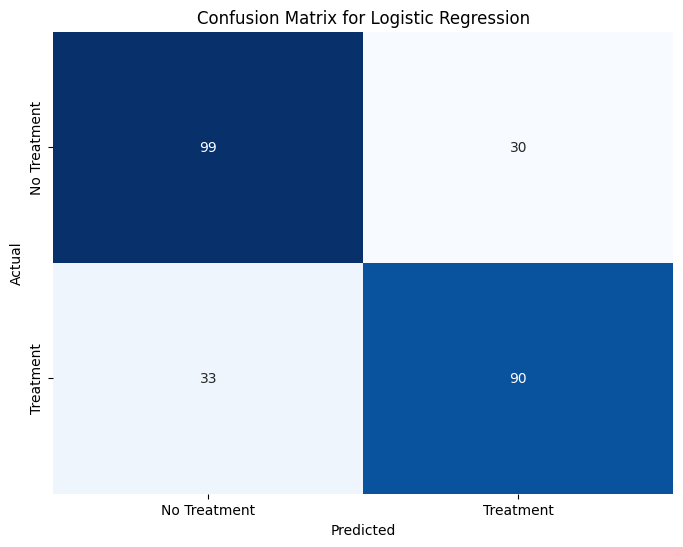

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

### 1. Distribution of the Target Variable (`treatment`)

/tmp/ipython-input-3801537594.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='treatment', data=df, palette='viridis')


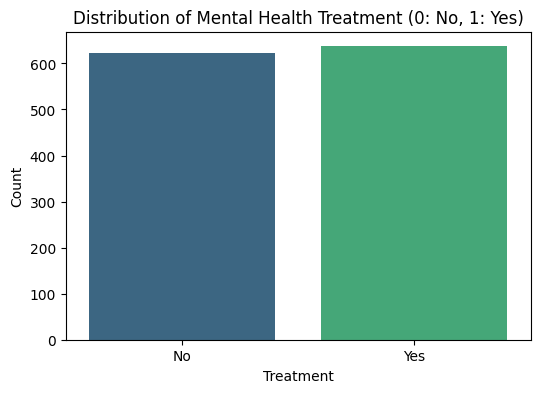

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='treatment', data=df, palette='viridis')
plt.title('Distribution of Mental Health Treatment (0: No, 1: Yes)')
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

### 2. Distribution of Age

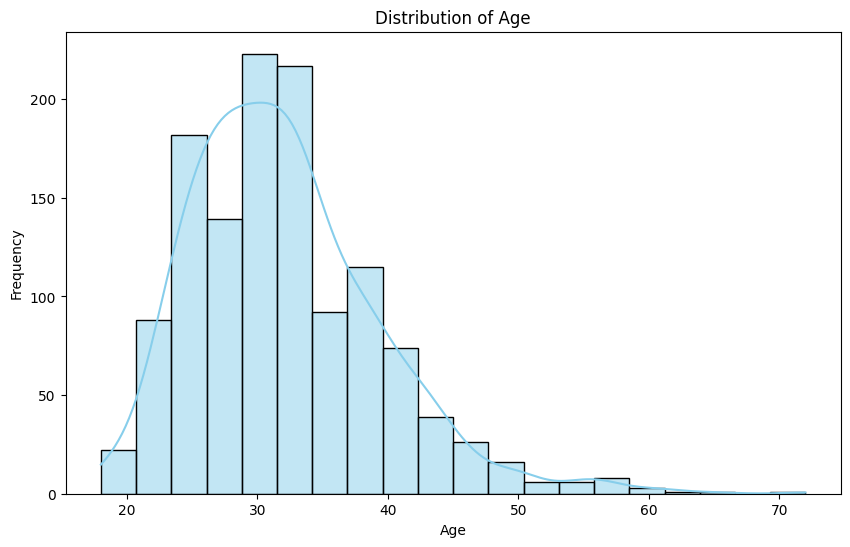

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### 3. Distribution of Gender

/tmp/ipython-input-3056452733.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender_Male', data=df, palette='magma')


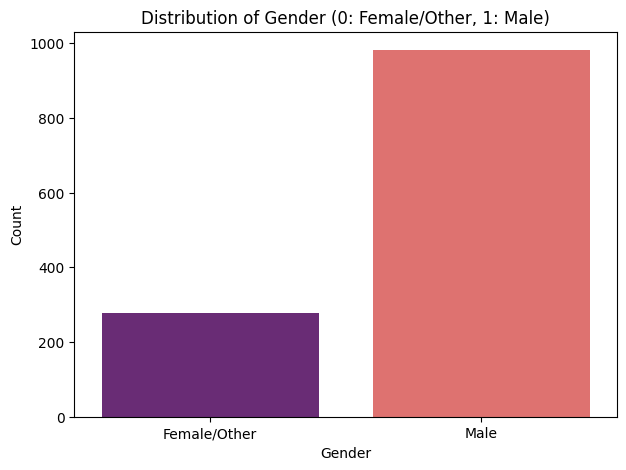

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Gender_Male', data=df, palette='magma')
plt.title('Distribution of Gender (0: Female/Other, 1: Male)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Female/Other', 'Male'])
plt.show()

### 4. Relationship between Gender and Treatment

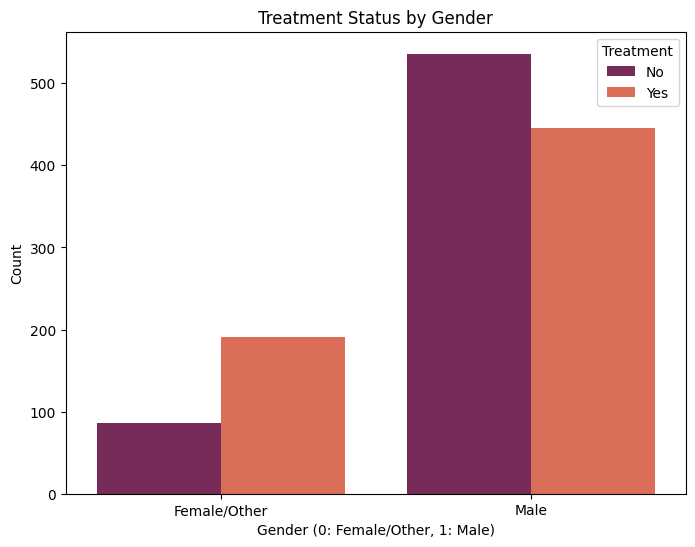

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender_Male', hue='treatment', data=df, palette='rocket')
plt.title('Treatment Status by Gender')
plt.xlabel('Gender (0: Female/Other, 1: Male)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Female/Other', 'Male'])
plt.legend(title='Treatment', labels=['No', 'Yes'])
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Instantiate a Logistic Regression model
# Set max_iter for 'lbfgs' and 'saga' to ensure convergence, especially with smaller C values
# The max_iter will be handled by GridSearchCV if a solver requiring it is chosen
log_reg = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for robust solvers

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           cv=5, # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1, # Use all available cores
                           verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:", grid_search.best_params_)

# Retrain a new Logistic Regression model with the best parameters
tuned_model = LogisticRegression(**grid_search.best_params_, random_state=42, max_iter=1000)
tuned_model.fit(X_train, y_train)

print("Logistic Regression model retrained with best parameters.")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'C': 10, 'solver': 'lbfgs'}
Logistic Regression model retrained with best parameters.


Accuracy Score of Tuned Model: 0.7421

Confusion Matrix for Tuned Model:
[[97 32]
 [33 90]]


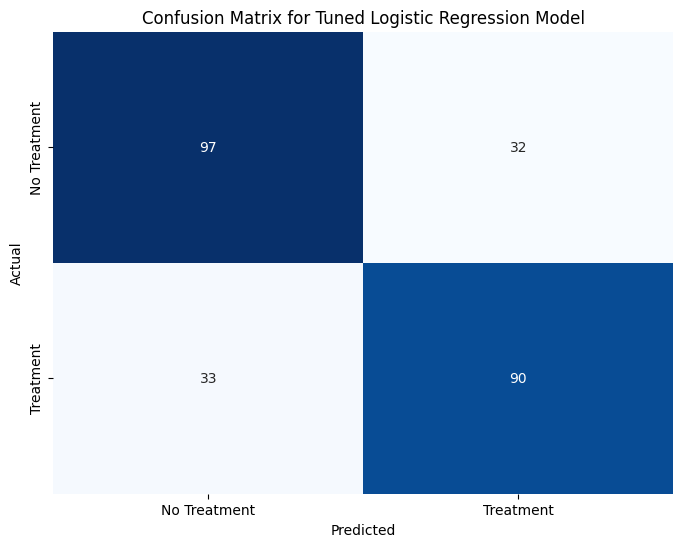

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate accuracy
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy Score of Tuned Model: {accuracy_tuned:.4f}")

# Generate confusion matrix for the tuned model
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nConfusion Matrix for Tuned Model:")
print(conf_matrix_tuned)

# Visualize the confusion matrix for the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned Logistic Regression Model')
plt.show()

In [ ]:
print("Value counts for 'treatment' column:")
print(df['treatment'].value_counts())

print("\nPercentage of each class in 'treatment' column:")
print(df['treatment'].value_counts(normalize=True) * 100)

Value counts for 'treatment' column:
treatment
1    637
0    622
Name: count, dtype: int64

Percentage of each class in 'treatment' column:
treatment
1    50.595711
0    49.404289
Name: proportion, dtype: float64


In [ ]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training target shape:", y_train.shape)
print("Resampled training target shape:", y_train_resampled.shape)
print("\nValue counts of original y_train:")
print(y_train.value_counts())
print("\nValue counts of resampled y_train:")
print(y_train_resampled.value_counts())

Original training target shape: (1007,)
Resampled training target shape: (1028,)

Value counts of original y_train:
treatment
1    514
0    493
Name: count, dtype: int64

Value counts of resampled y_train:
treatment
0    514
1    514
Name: count, dtype: int64


Top 10 most important features and their importances:
family_history_Yes          0.091082
Age                         0.081222
work_interfere_Often        0.039583
care_options_Yes            0.038394
Gender_Male                 0.026193
work_interfere_Sometimes    0.022182
work_interfere_Rarely       0.021819
anonymity_Yes               0.020573
obs_consequence_Yes         0.020572
care_options_No             0.020533
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier on the resampled training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Extract feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train_resampled.columns)

# Select the top 10 most important features
top_10_features = feature_importances.nlargest(10)

print("Top 10 most important features and their importances:")
print(top_10_features)

In [ ]:
selected_features = top_10_features.index.tolist()

X_train_selected = X_train_resampled[selected_features]
X_test_selected = X_test[selected_features]

print("New training data shape (X_train_selected):", X_train_selected.shape)
print("New testing data shape (X_test_selected):", X_test_selected.shape)
print("\nFirst 5 rows of X_train_selected:")
display(X_train_selected.head())
print("\nFirst 5 rows of X_test_selected:")
display(X_test_selected.head())

New training data shape (X_train_selected): (1028, 10)
New testing data shape (X_test_selected): (252, 10)

First 5 rows of X_train_selected:


,family_history_Yes,Age,work_interfere_Often,care_options_Yes,Gender_Male,work_interfere_Sometimes,work_interfere_Rarely,anonymity_Yes,obs_consequence_Yes,care_options_No
0,False,25,False,False,True,True,False,True,False,True
1,True,38,False,False,True,True,False,True,False,False
2,True,26,False,False,False,True,False,False,False,True
3,True,28,False,False,True,True,False,False,False,True
4,False,30,False,False,True,True,False,False,False,True



First 5 rows of X_test_selected:


,family_history_Yes,Age,work_interfere_Often,care_options_Yes,Gender_Male,work_interfere_Sometimes,work_interfere_Rarely,anonymity_Yes,obs_consequence_Yes,care_options_No
76,False,25,False,True,True,True,False,False,False,False
1026,False,25,False,True,False,False,False,False,False,False
43,False,18,True,False,True,False,False,False,False,False
666,False,22,False,False,True,True,False,False,True,True
529,True,31,False,False,False,True,False,False,False,False


Accuracy Score with Selected Features: 0.7500

Confusion Matrix with Selected Features:
[[96 33]
 [30 93]]


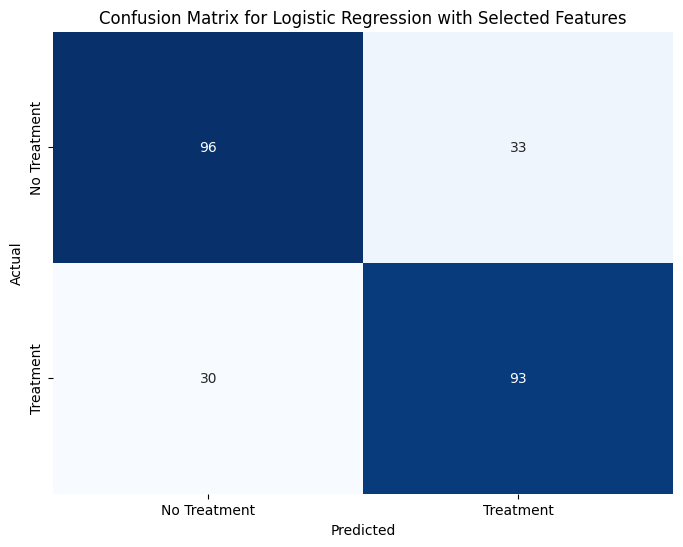

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instantiate a Logistic Regression model
logreg_selected = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')

# 2. Train this model using the X_train_selected and y_train_resampled datasets
logreg_selected.fit(X_train_selected, y_train_resampled)

# 3. Make predictions on the X_test_selected data
y_pred_logreg_selected = logreg_selected.predict(X_test_selected)

# 4. Calculate and print the accuracy score
accuracy_selected = accuracy_score(y_test, y_pred_logreg_selected)
print(f"Accuracy Score with Selected Features: {accuracy_selected:.4f}")

# 5. Generate and print the confusion matrix
conf_matrix_selected = confusion_matrix(y_test, y_pred_logreg_selected)
print("\nConfusion Matrix with Selected Features:")
print(conf_matrix_selected)

# 6. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Selected Features')
plt.show()

Accuracy Score for RandomForest with Selected Features: 0.6667

Confusion Matrix for RandomForest with Selected Features:
[[90 39]
 [45 78]]


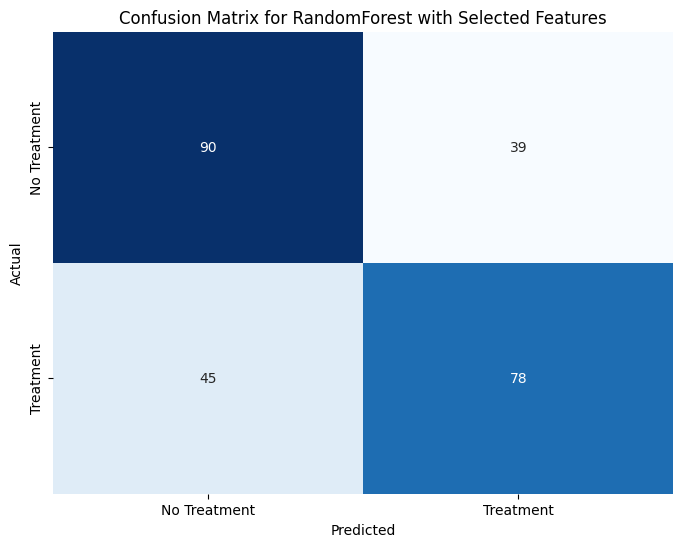

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instantiate a RandomForestClassifier
rf_classifier_selected = RandomForestClassifier(random_state=42)

# 2. Train the classifier using the X_train_selected and y_train_resampled datasets
rf_classifier_selected.fit(X_train_selected, y_train_resampled)

# 3. Make predictions on the X_test_selected data
y_pred_rf_selected = rf_classifier_selected.predict(X_test_selected)

# 4. Calculate and print the accuracy score
accuracy_rf_selected = accuracy_score(y_test, y_pred_rf_selected)
print(f"Accuracy Score for RandomForest with Selected Features: {accuracy_rf_selected:.4f}")

# 5. Generate and print the confusion matrix
conf_matrix_rf_selected = confusion_matrix(y_test, y_pred_rf_selected)
print("\nConfusion Matrix for RandomForest with Selected Features:")
print(conf_matrix_rf_selected)

# 6. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_selected, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForest with Selected Features')
plt.show()

Accuracy Score for SVC with Selected Features: 0.5992

Confusion Matrix for SVC with Selected Features:
[[109  20]
 [ 81  42]]


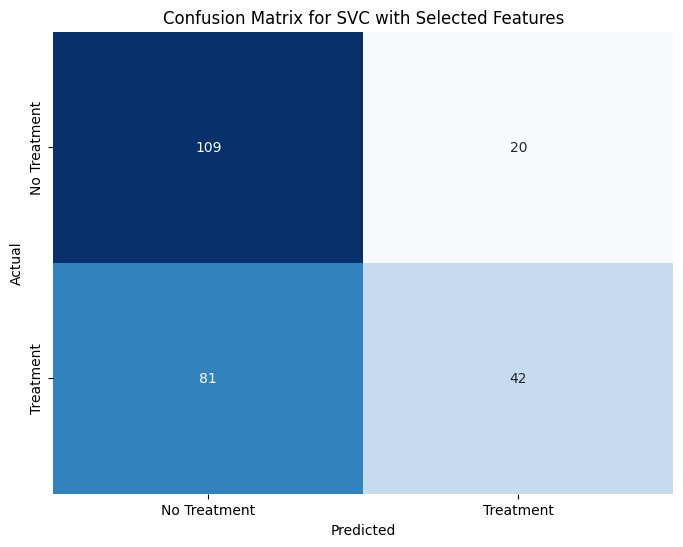

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instantiate an SVC model
svc_selected = SVC(random_state=42, probability=True) # probability=True for future potential use

# 2. Train the SVC classifier using the X_train_selected and y_train_resampled datasets
svc_selected.fit(X_train_selected, y_train_resampled)

# 3. Make predictions on the X_test_selected data
y_pred_svc_selected = svc_selected.predict(X_test_selected)

# 4. Calculate and print the accuracy score
accuracy_svc_selected = accuracy_score(y_test, y_pred_svc_selected)
print(f"Accuracy Score for SVC with Selected Features: {accuracy_svc_selected:.4f}")

# 5. Generate and print the confusion matrix
conf_matrix_svc_selected = confusion_matrix(y_test, y_pred_svc_selected)
print("\nConfusion Matrix for SVC with Selected Features:")
print(conf_matrix_svc_selected)

# 6. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc_selected, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVC with Selected Features')
plt.show()

Accuracy Score for GradientBoostingClassifier with Selected Features: 0.7302

Confusion Matrix for GradientBoostingClassifier with Selected Features:
[[92 37]
 [31 92]]


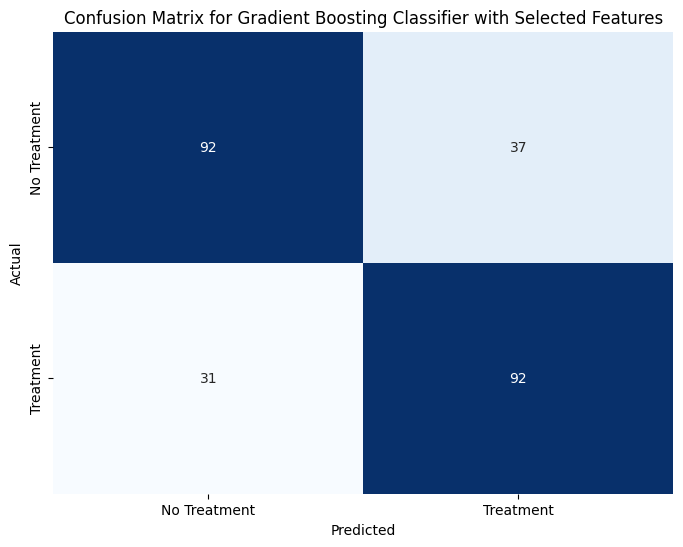

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instantiate a GradientBoostingClassifier model
gbc_selected = GradientBoostingClassifier(random_state=42)

# 2. Train the classifier using the X_train_selected and y_train_resampled datasets
gbc_selected.fit(X_train_selected, y_train_resampled)

# 3. Make predictions on the X_test_selected data
y_pred_gbc_selected = gbc_selected.predict(X_test_selected)

# 4. Calculate and print the accuracy score
accuracy_gbc_selected = accuracy_score(y_test, y_pred_gbc_selected)
print(f"Accuracy Score for GradientBoostingClassifier with Selected Features: {accuracy_gbc_selected:.4f}")

# 5. Generate and print the confusion matrix
conf_matrix_gbc_selected = confusion_matrix(y_test, y_pred_gbc_selected)
print("\nConfusion Matrix for GradientBoostingClassifier with Selected Features:")
print(conf_matrix_gbc_selected)

# 6. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbc_selected, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Classifier with Selected Features')
plt.show()

In [ ]:
import pandas as pd

# 1. Create a dictionary to store the accuracy scores of each model
model_accuracies = {
    'Logistic Regression (Selected Features)': accuracy_selected,
    'Random Forest (Selected Features)': accuracy_rf_selected,
    'SVC (Selected Features)': accuracy_svc_selected,
    'Gradient Boosting (Selected Features)': accuracy_gbc_selected
}

# 2. Convert this dictionary into a pandas Series for better presentation
accuracy_df = pd.Series(model_accuracies, name='Accuracy Score').sort_values(ascending=False)

# 3. Print the accuracy scores of all models
print("\nModel Accuracy Comparison (with Selected Features):\n")
print(accuracy_df)


Model Accuracy Comparison (with Selected Features):

Logistic Regression (Selected Features)    0.750000
Gradient Boosting (Selected Features)      0.730159
Random Forest (Selected Features)          0.666667
SVC (Selected Features)                    0.599206
Name: Accuracy Score, dtype: float64


### Plotting ROC Curve for the Best-Performing Model (Logistic Regression with Selected Features)

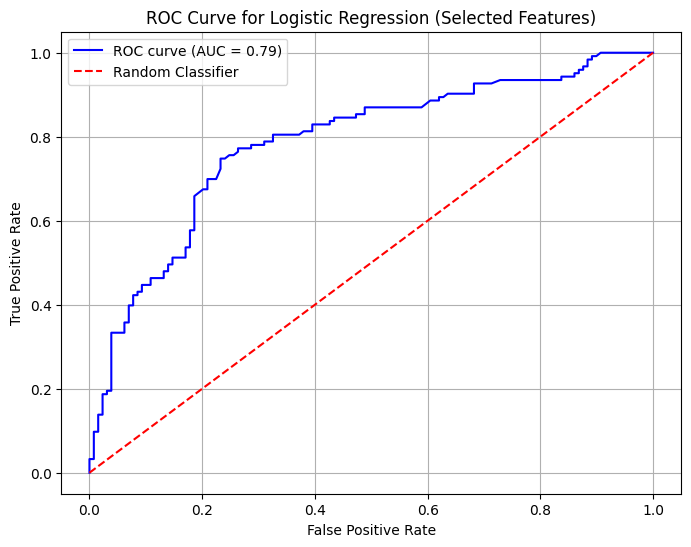

AUC Score for Logistic Regression (Selected Features): 0.7851


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ensure the best performing model is available
# In this case, 'logreg_selected' was the best performing model (Logistic Regression with Selected Features)

# Predict probabilities for the positive class (1)
y_pred_proba = logreg_selected.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (Selected Features)')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC Score for Logistic Regression (Selected Features): {auc_score:.4f}")